In [1]:
import json
import os
import pickle
from pathlib import Path
from joblib import Parallel, delayed

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import rioxarray
import seaborn as sns
from tqdm import tqdm
from xrspatial.multispectral import ndvi, savi
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/michael/TreeMortality/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_unique_ID(crowns, utm_zone):
    '''
    returns copy of dataframe with new uniqueID column
    with entries of form 'utm_zone_x_y where x and y 
    are rounded to the nearest meter.
    TODO: make it round to nearest even meter to lower precision
    '''
    crowns['UniqueID'] = crowns.geometry.centroid.apply(
        lambda p: f'{utm_zone}_{p.x:.0f}_{p.y:.0f}')
    
    return crowns


def make_model_inputs(crowns, tif_path, label=None, IDcolumn=None):
    '''
    Returns DataFrame with features for use in classification model.
    The resulting DataFrame has 'ID' column which matches that in crowns.
    The DataFrame also has a 'label' column, see params for more detail.  

    params:
        crowns   - str - path to OGR readable vector file containing tree crowns.
        tif_path - str - path to image tif used in producing features.
        label    - str - specifies column containing labels.  If specified 'label'
                         column in resulting DataFrame will contain contents of 
                         specified column. Otherwise 'label' column contain -99.
        IDcolumn - str - column to use as matching ID with crowns
    '''

    # get the extent of the crowns
    xmin, ymin, xmax, ymax = crowns.total_bounds

    # open the naip image
    xa = rioxarray.open_rasterio(tif_path).astype(float).rio.clip_box(
        minx=xmin,
        miny=ymin,
        maxx=xmax,
        maxy=ymax
        ).to_dataset(name='band_data')

    # normalized the band_data
    band_data = xa.band_data.to_numpy().astype(float)
    band_data = (
        (band_data - np.nanmin(band_data))
        * (255 / (np.nanmax(band_data) - np.nanmin(band_data)))
        )

    # calculate relative greenness
    red = band_data[0]
    green = band_data[1]
    blue = band_data[2]
    nir = band_data[3]
    rgi = green / (red + green + blue)
    xa['rgi'] = (('y', 'x'), rgi)

    # calculate pixel by pixel normalized R, G, B, and NIR
    rgbn_tot = red + green + blue + nir
    xa['red_'] = (('y', 'x'), red  / rgbn_tot)
    xa['blue_'] = (('y', 'x'), blue  / rgbn_tot)
    xa['green_'] = (('y', 'x'), green  / rgbn_tot)
    xa['nir_'] = (('y', 'x'), nir  / rgbn_tot)

    # calculate NDVI and SAVI
    nir_agg = xa.band_data[3].astype(float)
    red_agg = xa.band_data[2].astype(float)
    ndvi_agg = ndvi(nir_agg, red_agg)
    savi_agg = savi(nir_agg, red_agg)
    xa['NDVI'] = ndvi_agg
    xa['SAVI'] = savi_agg

    # calculate RGB luminosity
    luminosity = band_data[:3].mean(axis=0) / 255
    xa['luminosity'] = (('y', 'x'), luminosity)

    # mask out shadows and soil for RGI,NDVI, and normed pix colors
    mask = (luminosity > 0.176) & (luminosity < 0.569)
    masked_rgi = xa.rgi.where(mask)
    masked_ndvi = xa.NDVI.where(mask)
    r_ = xa.red_.where(mask)
    g_ = xa.green_.where(mask)
    b_ = xa.blue_.where(mask)
    n_ = xa.nir_.where(mask)
    
    data = []
    masked_count = 0
    total = len(crowns)
    bins = np.arange(0.1, 1.1, 0.1)
    
    for _, row in crowns.iterrows():
        # calculate luminosity fractions
        lum = xa.luminosity.rio.clip([row.geometry]).to_numpy().flatten()
        lum_tot = lum.shape[0]
        lum_fracs = [
            ((lum < f).sum() - (lum < f - 0.1).sum())
            / lum_tot
            for f in bins
            ]

        # calculate rgi fracs
        rgi = masked_rgi.rio.clip([row.geometry]).to_numpy().flatten()
        rgi = rgi[~np.isnan(rgi)]
        rgi_tot = len(rgi)
        if rgi_tot == 0:
            rgi_fracs = [-99] * 10
        else:
            rgi_fracs = [
                ((rgi < f).sum() - (rgi < f - 0.1).sum())
                / rgi_tot
                for f in bins
                ]
            
        # clip normed rgbn ro crown
        r = r_.rio.clip([row.geometry]).to_numpy().flatten()
        r = r[~np.isnan(r)]
        
        g = g_.rio.clip([row.geometry]).to_numpy().flatten()
        g = g[~np.isnan(g)]

        b = b_.rio.clip([row.geometry]).to_numpy().flatten()
        b = b[~np.isnan(b)]

        n = n_.rio.clip([row.geometry]).to_numpy().flatten()
        n = n[~np.isnan(n)]

        # get number of unmasked pix within crown
        c_tot = len(r)

        if c_tot == 0:
        # if there are no unmasked pix in crown fill with -99
            r_fracs = [-99] * 10
            g_fracs = [-99] * 10
            b_fracs = [-99] * 10
            n_fracs = [-99] * 10
        else:
            # calculate normed pix color fracs
            r_fracs = [
                ((r < f).sum() - (r < f - 0.1).sum())
                / c_tot
                for f in bins
                ]

            g_fracs = [
                ((g < f).sum() - (g < f - 0.1).sum())
                / c_tot
                for f in bins
                ]

            b_fracs = [
                ((b < f).sum() - (b < f - 0.1).sum())
                / c_tot
                for f in bins
                ]

            n_fracs = [
                ((n < f).sum() - (n < f - 0.1).sum())
                / c_tot
                for f in bins
                ]

        # calculate means and stdevs
        if rgi_tot == 0:
            ndvi_mean, ndvi_std = -99, -99
            rgi_mean, rgi_std = -99, -99
            savi_mean, savi_std = -99, -99
            r_mean, r_std = -99, -99
            g_mean, g_std = -99, -99
            b_mean, b_std = -99, -99
            n_mean, n_std = -99, -99
        else:
            #NOTE: .values * 1 casts 1 item DataArray to float
            ndvi_mean = masked_ndvi.mean().values * 1
            ndvi_std = masked_ndvi.std().values * 1
            rgi_mean = rgi.mean() 
            rgi_std = rgi.std()
            savi_mean = xa.SAVI.mean().values * 1
            savi_std = xa.SAVI.std().values * 1
            r_mean, r_std = r.mean(), r.std()
            g_mean, g_std = g.mean(), g.std()
            b_mean, b_std = b.mean(), b.std()
            n_mean, n_std = n.mean(), n.std()

        if label is None:
            row[label] = -99

        data.append(
            [row[IDcolumn], (row[label] + 1) / 2] +
            lum_fracs +
            rgi_fracs + 
            r_fracs + 
            g_fracs + 
            b_fracs + 
            n_fracs +
            [ndvi_mean, ndvi_std, rgi_mean, rgi_std, savi_mean, savi_std] +
            [r_mean, r_std, g_mean, g_std, b_mean, b_std, n_mean, n_std]
            )

    cols = [
        IDcolumn, 'label',
        'lum10', 'lum20', 'lum30', 'lum40', 'lum50',
        'lum60' ,'lum70', 'lum80', 'lum90', 'lum100',
        'rgi10', 'rgi20', 'rgi30', 'rgi40', 'rgi50',
        'rgi60' ,'rgi70', 'rgi80', 'rgi90', 'rgi100',
        'r10', 'r20', 'r30', 'r40', 'r50',
        'r60' ,'r70', 'r80', 'r90', 'r100',
        'g10', 'g20', 'g30', 'g40', 'g50',
        'g60' ,'g70', 'g80', 'g90', 'g100',
        'b10', 'b20', 'b30', 'b40', 'b50',
        'b60' ,'b70', 'b80', 'b90', 'b100',
        'n10', 'n20', 'n30', 'n40', 'n50',
        'n60' ,'n70', 'n80', 'n90', 'n100',
        'ndvi_mean', 'ndvi_std',
        'rgi_mean', 'rgi_std',
        'savi_mean', 'savi_std',
        'r_mean', 'r_std',
        'g_mean', 'g_std',
        'b_mean', 'b_std',
        'n_mean', 'n_std'
        ]

    return pd.DataFrame(data, columns=cols)


def ll_features(gpkg, tif_path, label=None, IDcolumn=None, label_col='label'):
    '''
    Wrapper for reading crowns and engineering model features
    for use with joblib Parallel.
    Returns a tuple containing the tile identifier (str) and 
    Pandas df of model input features.
    '''
    # get tile identifier
    tile = (os.path.basename(gpkg)).split('_labels')[0]
    # read the crown polygons
    crowns = gpd.read_file(gpkg).dropna(
        subset=[label_col]
        ).set_index('IDdalponte', drop=False)
    crowns = crowns[crowns.geometry.area > 10]
    
    # make uniqueID
    crowns = make_unique_ID(crowns, 10)
    
    return (tile, make_model_inputs(crowns, tif_path, label=label_col, IDcolumn=IDcolumn))


def make_features():
    '''
    Builds features from training data.
    Returns a tuple containing the tile identifier (str) and 
    Pandas df of model input features.
    '''
    # open dict of {labeled_polygon: NAIP} pairs from config file
    with open(Path(os.getcwd()) / 'model_config.json') as src:
        config = json.load(src)

    label_col = 'label'

    # open crowns and make features TODO: unhardcode n_jobs using args
    results = Parallel(n_jobs=3)(delayed(ll_features)(
        gpkg,
        tif,
        label=label_col,
        IDcolumn='UniqueID')
        for gpkg, tif in config.items()
    )
    data = dict(results)
    
    return data

In [3]:
data = make_features()

Warning 1: /home/michael/TreeMortality/data/huc180102111102/NAIP/2020/m_4012316_sw_10_060_20200710.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /home/michael/TreeMortality/data/huc180102111102/NAIP/2020/m_4012324_nw_10_060_20200710.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /home/michael/TreeMortality/data/huc180102111102/NAIP/2020/m_4012324_sw_10_060_20200710.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/home/michael/TreeMortality/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too sh

In [4]:
# get the model params determined in `mortality_classification.ipynb`
with open('model_params.json') as src:
    params = json.load(src)
params.keys()

dict_keys(['n_estimators', 'max_features', 'max_depth', 'np.random.seed', 'columns'])

In [5]:
tiles =  list(data.keys())
confusion_matrices = []

for i in range(len(tiles)):
    # separate train and validation sets
    test = data[tiles[i]]
    train_tiles = tiles[:i] + tiles[i+1:]
    train = [data[tile] for tile in train_tiles]
    train = pd.concat(train)
    
    # this is to fix old style labels, does not effect new style labels
    train['y'] = train.label.round().astype(int)
    test['y'] = test.label.round().astype(int)
    
    # seperate features and labels
    cols = train.drop(['y', 'label', 'UniqueID'], axis=1).columns
    X = train[cols]
    y = train.y
    
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_features=params['max_features'],
        max_depth=params['max_depth'],
        oob_score=False,
        random_state=np.random.seed(params['np.random.seed'])
    ).fit(X, y)
    
    X_test = test[cols]
    y_test = test.y
    pred = model.predict(X_test)
    try:
        roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    except ValueError:
        roc = np.nan
    acc = accuracy_score(y_test, pred)
    print(tiles[i])
    print(f'\tROC UAC:{roc:.2f}')
    print(f'\tAccuracy:{acc:.2f}')
    
    confusion_matrices.append(confusion_matrix(y_test, pred))

10TEL0509245547_2022
	ROC UAC:0.97
	Accuracy:0.93
10TDL0458245240_2022
	ROC UAC:0.99
	Accuracy:0.97
10TEK0503244655_2022
	ROC UAC:0.92
	Accuracy:0.85
10TDL0464245187_2022
	ROC UAC:1.00
	Accuracy:0.99
10TDL0480045075_2020
	ROC UAC:0.99
	Accuracy:1.00
10TDL0480045075_2022
	ROC UAC:1.00
	Accuracy:0.98
10TDL0480045075_2018
	ROC UAC:nan
	Accuracy:0.96
10TEK0500244992_2022
	ROC UAC:1.00
	Accuracy:0.99
10TDL0488245360_2022
	ROC UAC:1.00
	Accuracy:0.98


In [8]:
tiles[0]

'10TEL0509245547_2022'

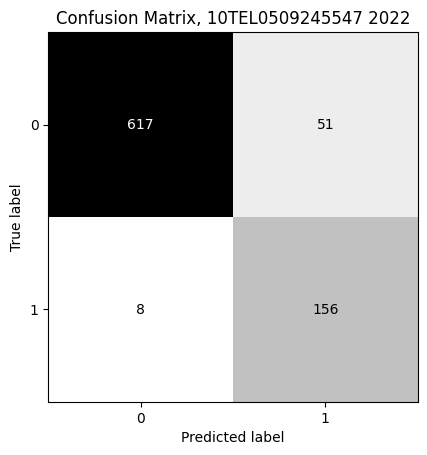

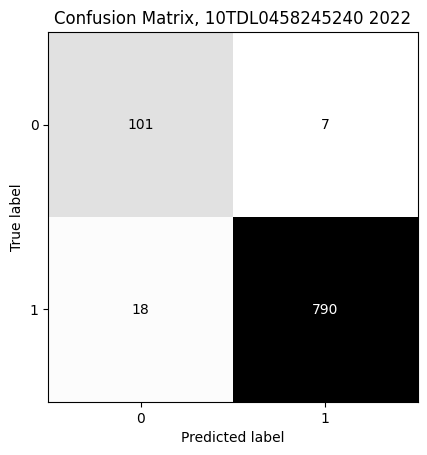

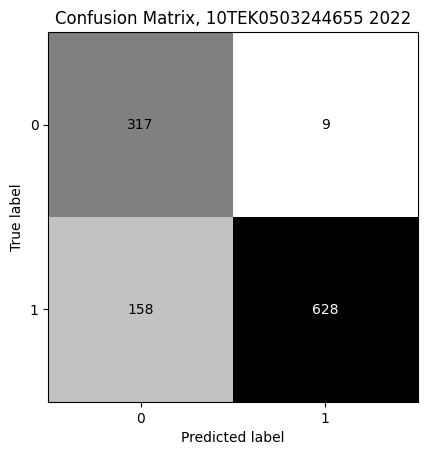

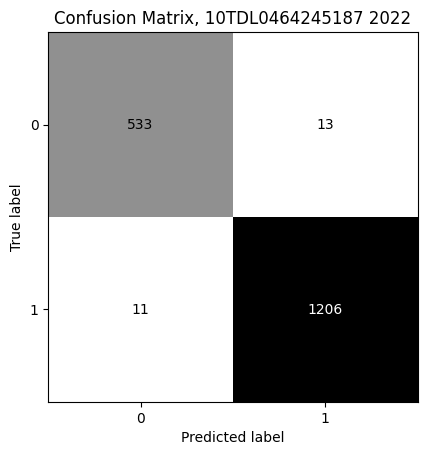

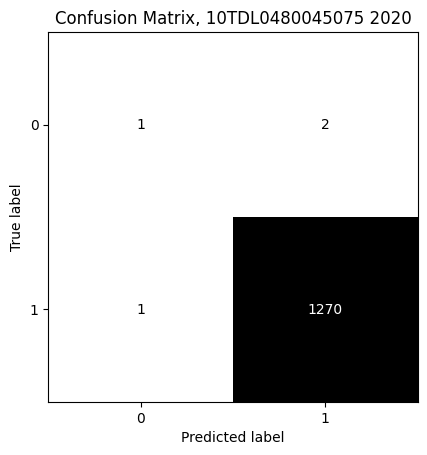

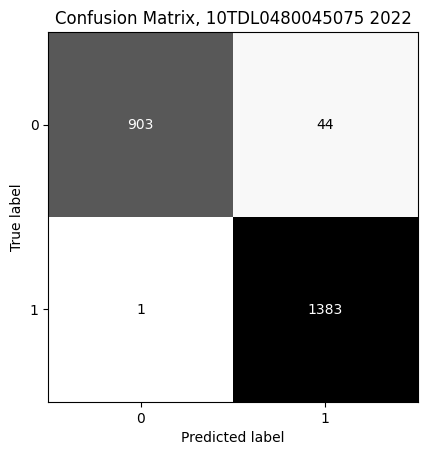

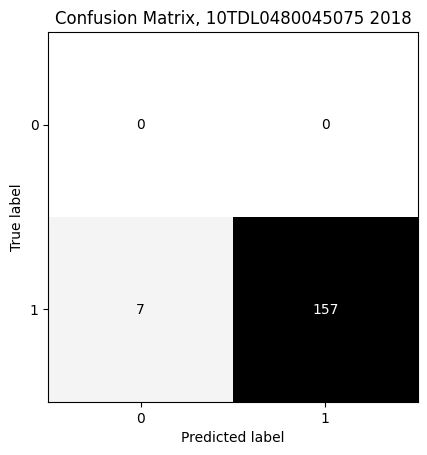

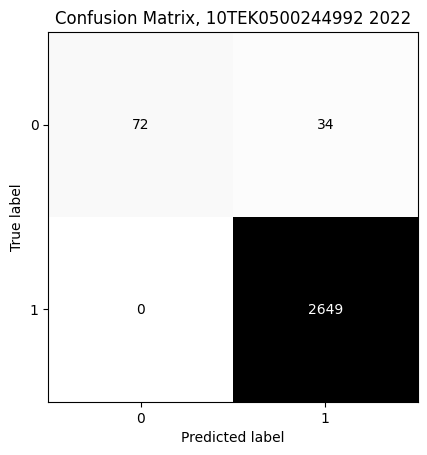

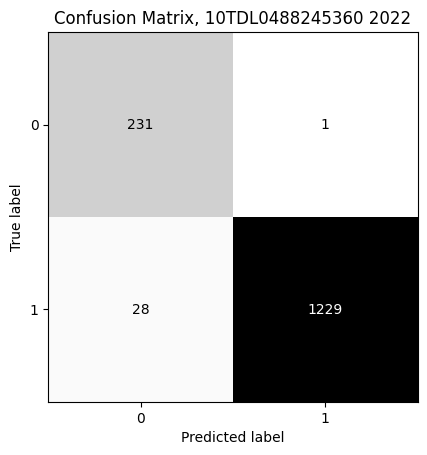

In [11]:
for i, cm in enumerate(confusion_matrices):
        d = cm_display1 = ConfusionMatrixDisplay(cm).plot(
                colorbar=False,
                cmap='binary'
                )

        ti = ' '.join(tiles[i].split('_'))
        plt.title(f'Confusion Matrix, {ti}');
        plt.savefig(f'/home/michael/thesis/images/confusion_{tiles[i]}.png')
        plt.close()

In [ ]:


fig, axes = plt.subplots(nrows=len(tiles // 2), ncols=2, figsize=(15,10))
axes

In [ ]:

for cm in confusion_matrices:
    cm_display1 = ConfusionMatrixDisplay(cm).plot(
        colorbar=False,
        cmap='binary'
        )

    plt.title('Confusion Matrix for Test Data')
    
plt.savefig('/home/michael/thesis/images/confusion_test.png')

In [ ]:
path_10TDL0458245240 = '/home/michael/TreeMortality/data/huc180102111107/crowns/10TDL0458245240.gpkg'

crowns = gpd.read_file(gpkg).dropna(
        subset=[label_col]
        ).set_index('IDdalponte', drop=False)
crowns = crowns[crowns.geometry.area > 10]
    
# make uniqueID
crowns = make_unique_ID(crowns, 10)




for y in [2018, 2020, 2022]:
    naip = f'/home/michael/TreeMortality/data/huc180102111105/NAIP/{y}/{y}.vrt'
    data = make_model_inputs(crowns, naip, IDcolumn='UniqueID')
    X = data[cols]
    y_pred = model.predict_proba(X)[:, 1]
